# Demo de implementación de un algoritmo de Sistema Inmunológico Artificial (SIAL) del tipo CLONALG para resolver un SUDOKU intentando reducir la cantidad de errores
Utiliza la librería DEAP disponible en https://deap.readthedocs.io/en/master/

In [1]:
#@title Instalar librerías
!pip install deap

In [2]:
#@title Cargar librerías
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from deap import base
from deap import creator
from deap import tools

try:
    from collections.abc import Sequence
except ImportError:
    from collections import Sequence
from itertools import repeat

import copy

import matplotlib
import matplotlib.pyplot as plt
import networkx
from IPython.display import display
from PIL import Image

import matplotlib as mpl
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import ipywidgets as widgets
from ipywidgets import Box, Layout, IntSlider
from ipywidgets import Layout
from IPython.display import clear_output

print("\nLibrerías importadas")


Librerías importadas


In [3]:
#@title PARÁMETROS


#@markdown Parámetros del Algoritmo CLONALG:

# Cantidad de Ciclos de la Corrida
CANT_CICLOS = 5000 #@param {type:"integer"}

# Cantidad de Individuos en la Población
CANT_INDIVIDUOS_POBLACION = 50  #@param {type:"slider", min:1, max:100, step:1}

print("\nParámetros de la Corrida definidos")


Parámetros de la Corrida definidos


In [4]:
#@title clase SUDOKU

# @markdown Tamaño del Tablero:
Tamaño_Sudoku_NxN = '9x9'  #@param [ '4x4', '9x9', '16x16', '25x25' ]
# @markdown Indica cómo se asignan valores predefinidos del Tablero (Manual o Azar):
Manual_Valores_Predefinidos_Lista = '  4  7 3            5   7        2   6  73      8     8     3   4 3   7 1    89 6' #@param {type:"string"}
Azar_Cantidad_Valores_Predefinidos = 5 # @param {type:"slider", min:0, max:25, step:1}

# posibles valores a usar en el sudoku
SUDOKU_VALORES_POSIBLES = [' ', '1','2','3','4','5','6','7','8','9', '0', 'A','B','C','D','E','F','G','H','I','J','K','L','M','N','Ñ','O','P','Q','R','S','T','U','V','W','X','Y','Z', '!','?','#','$','%','&','/','+','*','-']

# clase Sudoku
class Sudoku(object):

    def __init__(self, Tamaño_NxN='9x9'):
      # determina tamaño del tablero (siempre es cuadrado)
      try:
        self._N = int(Tamaño_NxN.lower().split("x")[0])
      except:
        print("No se puede definir tamaño del tablero, se usa valor por defecto 9x9!")
      # determina tamaño filas / columnas (N - 1)
      self._tamFilaCol = self._N-1
      # obtiene el tamaño de las regiones (raiz cuadrada de N)
      self._tamRegion = int(self._N**0.5)
      if (self._tamRegion**2) !=  self._N:
        # controla que el tamaño es un cuadrado perfecto
        raise Exception("El tamaño del tablero no es válido: " + str(self._N) + "x" + str(self._N) + "!")
      # determina valores a usar
      if len(SUDOKU_VALORES_POSIBLES) < (self._N+1):
        # controla que haya definidos valores para tamaño tablero
        raise Exception("No existen suficientes valores (" + str(len(SUDOKU_VALORES_POSIBLES)) + ") para el tamaño del tablero: " + str(self._N) + "x" + str(self._N) + "!")
      self._ValoresUsar = SUDOKU_VALORES_POSIBLES[0: self._N+1]
      # inicializa los vectores que representan el tablero
      self.Tablero = np.zeros((self._tamFilaCol+1, self._tamFilaCol+1))

    # Función para definir los valores predefinidos del tablero al azar
    def asignarValoresAlAzar(self, cantidad=1):
      for _ in range(cantidad):
          NoAgrego = True
          cantIt = 0
          while (NoAgrego and (cantIt<100)):
            cantIt += 1
            # define posición al azar
            auxPosX = random.randint(0, self._tamFilaCol)
            auxPosY = random.randint(0, self._tamFilaCol)
            # controla que el valor no este asignado
            if self.Tablero[auxPosX][auxPosY]==0:
              # determina valor a asignar
              auxVal = random.randint(1, len(self._ValoresUsar)-1)
              # prueba agregarlo
              self.Tablero[auxPosX][auxPosY] = auxVal
              # controla que no genere error
              cantErr = self.cuentaErrores()
              if cantErr[0]==0:
                # está bien, lo deja
                NoAgrego = False
              else:
                # genera error, resetea tablero
                self.Tablero[auxPosX][auxPosY] = 0

    # Función para asignar manualmente un valor
    def asignarValorManual(self, posX, posY, valor, showMessage=False):
        # chequea posiciones
        posX = posX - 1
        if posX < 0:
          posX = 0
        elif posX > self._tamFilaCol:
          posX = self._tamFilaCol
        posY = posY - 1
        if posY < 0:
          posY = 0
        elif posY > self._tamFilaCol:
          posY = self._tamFilaCol
        # controla que el valor no este asignado
        if self.Tablero[posX][posY]>0:
          if showMessage:
            print("La posición [" + str(posX+1) + "," + str(posY+1) + "] ya está asignada: " + self._formatearValorPos(posX,posY) + "-> se ignora asignación!")
          return False
        # controla valor
        valor = str(valor)
        if valor not in self._ValoresUsar:
          if showMessage:
            print("Valor a asignar no válido: " + str(valor) + "-> se ignora asignación!")
          return False
        valorId = self._ValoresUsar.index(valor)
        # asigna
        self.Tablero[posX, posY] = valorId
        return True

    # Función para asigna valores a partir de una lista (individuo)
    def asignarValoresLista(self, valoresList, showMessage=False, esValorPos=False):
      # controla largo de lissta
      if len(valoresList) > self.devuelveTamanioTableroComoLista():
        if showMessage:
          print("Se indican más valores que los posibles a asignar, se ignora toda la lista!")
        return len(valoresList)
      # devuelve la cantidad de valores ignorados (por ya estar asignados)
      cantIgnorados = 0
      cantColumnas = self._tamFilaCol+1
      for posLista in range(len(valoresList)):
        # determina la posición
        posX = (posLista//cantColumnas)+1
        posY = (posLista%cantColumnas)+1
        valor = valoresList[posLista]
        if esValorPos:
            # el valor es el Id de Valores a usar
            valor = self._ValoresUsar[valor]
        else:
            # el valor es el Valor a usar
            valor = str(valor)
        # intenta asignarlo
        res = self.asignarValorManual(posX, posY, valor, showMessage=showMessage)
        if not(res):
          cantIgnorados += 1
      return cantIgnorados

    # Función para devolver el  tamaño debería tener el tablero como lista
    def devuelveTamanioTableroComoLista(self):
      return self._N**2

    # Función que devuelve el mínimo valor que se puede asignar en el tablero
    def devuelveMinimoValorAsignarEnTablero(self):
      return 1

    # Función que devuelve el máximo valor que se puede asignar en el tablero
    def devuelveMaximoValorAsignarEnTablero(self):
      return len(self._ValoresUsar)-1

    # Función auxiliar para contar duplicados por fila
    def _cuentaDuplicadosFila(self, matriz):
      cantDupl = 0
      for i in range(0, len(matriz)):
        uniqList, freqList = (np.unique(matriz[i], return_counts=True))
        for v, f in zip(uniqList, freqList):
          if (v>0) and (f>1):
            cantDupl += f-1
      return cantDupl

    # Función auxiliar para contar duplicados por region
    def _cuentaDuplicadosRegiones(self):
      cantDupl = 0
      rangoRegiones = range(len(self.Tablero)//self._tamRegion)
      for rX in rangoRegiones:
        # genera la región X
        iniRegionX = rX*self._tamRegion
        finRegionX = iniRegionX+self._tamRegion
        for rY in rangoRegiones:
          # genera la región Y
          auxRegion = []
          iniRegionY = rY*self._tamRegion
          finRegionY = iniRegionY+self._tamRegion
          for cols in self.Tablero[iniRegionX : finRegionX]:
            # genera la región
            auxRegion.append( cols[iniRegionY : finRegionY] )
          auxRegion = np.array(auxRegion)
          # cuenta duplicados en la region
          uniqList, freqList = (np.unique(auxRegion, return_counts=True))
          for v, f in zip(uniqList, freqList):
            if (v>0) and (f>1):
              cantDupl += f-1
      return cantDupl

    # Función para contar la cantidad de errores totales del sudo,u
    def cuentaErrores(self):
      # cuenta errores por filas
      errFilas = self._cuentaDuplicadosFila(self.Tablero)
      # cuenta errores por columnas (transpone el tablero)
      errColumnas = self._cuentaDuplicadosFila( np.transpose(self.Tablero) )
      # cuenta errores por sectores
      errRegiones = self._cuentaDuplicadosRegiones()
      # total errores
      errTotal = (errFilas+errColumnas+errRegiones)
      # sin definir
      cantZero = (self.Tablero == 0).sum()
      return errTotal, errFilas, errColumnas, errRegiones, cantZero

    # Función auxiliar para formatear valor a mostrar del tablero
    def _formatearValorPos(self, posX, posY):
      return self._ValoresUsar[ int(self.Tablero[posX][posY]) ]

    # Función que muestra la información sobre el Mapa de Búsqueda
    def printInformacion(self, mostrarErrores=True):
      print("\n** SUDOKU: " )
      ##print(self.Tablero)
      # formatea para demarcar las regiones
      print("\t", end="")
      print("--" * (self._tamFilaCol+1), end="-\n")
      for i in range(len(self.Tablero)):
        print("\t", end="|")
        for j in range(len(self.Tablero[i])):
          if j==0:
            carSep = " "
          elif ((j+1)%self._tamRegion)==0:
            carSep = "|"
          elif j==len(self.Tablero[i]):
            carSep = "|"
          else:
            carSep = " "
          print( self._formatearValorPos(i, j) , end=carSep)
        print("")
        if (((i+1)%self._tamRegion)==0) or (i==len(self.Tablero)):
          print("\t", end="")
          print("--" * (self._tamFilaCol+1), end="-\n")
      if mostrarErrores:
        # si corresponde muestra la cantidad de errores
        cantErrores = self.cuentaErrores()
        if cantErrores[4]>0:
          print("\n** Casilleros sin definir: ", cantErrores[4])
        if cantErrores[0]>0:
          print("\n** Cantidad de Errores: ", cantErrores[0])
          print("\t\t en Filas: ", cantErrores[1])
          print("\t\t en Columnas: ", cantErrores[2])
          print("\t\t en Regiones: ", cantErrores[3])
      print("\n")

print("\nClase SUDOKU definida")

# parámetros para función heruristica
PESO_IGNORADOS = 0
PESO_ERRORES_FILA = 1
PESO_ERRORES_COLUMNA = 1
PESO_ERRORES_REGION = 2
PESO_SIN_DEFINIR = 5

# clase wrapper Mapa para usar Sudoku con Abeja
class MapaSudoku(object):

  def __init__(self, sudokuOriginal, valMaximoGlobal=1000):
    self.sudokuOriginal = sudokuOriginal
    if valMaximoGlobal<0:
      self.valMaximoGlobal = sudokuOriginal.devuelveTamanioTableroComoLista()*(PESO_SIN_DEFINIR+PESO_ERRORES_REGION+PESO_ERRORES_COLUMNA+PESO_ERRORES_FILA+PESO_IGNORADOS)
    else:
      self.valMaximoGlobal = valMaximoGlobal

  @property
  def limMin(self):
    return self.sudokuOriginal.devuelveMinimoValorAsignarEnTablero()

  @property
  def limMax(self):
    return self.sudokuOriginal.devuelveMaximoValorAsignarEnTablero()

  @property
  def cantPosiciones(self):
    return self.sudokuOriginal.devuelveTamanioTableroComoLista()

  # genera nuevo soduku en base a la posiones
  def generarSudokuListaPos(self, listaPos):
    # hace una copia del sudoku original
    s = copy.deepcopy(self.sudokuOriginal)
    # prueba asignar los valores del individuo (lista valores)
    cantIgnorados = s.asignarValoresLista(list(listaPos), esValorPos=True)
    # calcula la cantidad de errores
    cantErrores = s.cuentaErrores()
    return s, cantIgnorados, cantErrores

  # definimos la función de aptitud a evaluar
  # se convierte el problema a maximizar para no afectar al algoritmo)
  def funcHeuristica(self, listaPos):
      # genera el sudoku
      _, cantIgnorados, cantErrores = self.generarSudokuListaPos(listaPos)
      # devuelve heurística
      h = self.valMaximoGlobal - (cantIgnorados*PESO_IGNORADOS
            + cantErrores[1]*PESO_ERRORES_FILA
            + cantErrores[2]*PESO_ERRORES_COLUMNA
            + cantErrores[3]*PESO_ERRORES_REGION
            + cantErrores[4]*PESO_SIN_DEFINIR)
      return h

  # muestra información
  def printInformacion(self, listaPos=None):
    if listaPos is None:
      s = self.sudokuOriginal
    else:
      s, _, _ = self.generarSudokuListaPos(listaPos)
    s.printInformacion(True)

print("\nClase MAPA-SUDOKU definida")

print("\n> Creando nuevo SUDOKU.")
sudokuOriginal = Sudoku(Tamaño_Sudoku_NxN)

# si tiene la lista mnual definida, la carga sino crea nueva clase
if Manual_Valores_Predefinidos_Lista != "":
  print("\n> Usando lista de valores predefinidos manual.")
  if "," in Manual_Valores_Predefinidos_Lista:
    listaAux = list(Manual_Valores_Predefinidos_Lista.split(","))
  else:
    listaAux = list(Manual_Valores_Predefinidos_Lista)
  sudokuOriginal.asignarValoresLista(listaAux, esValorPos=False, showMessage=True)
else:
  # asigna valores iniciales al azar
  if Azar_Cantidad_Valores_Predefinidos > 0:
    print("\n> Usando valores predefinidos al azar.")
    sudokuOriginal.asignarValoresAlAzar(Azar_Cantidad_Valores_Predefinidos)

# lo muestra
sudokuOriginal.printInformacion()

# inicializa mapa auxiliar
mapa = MapaSudoku(sudokuOriginal)



Clase SUDOKU definida

Clase MAPA-SUDOKU definida

> Creando nuevo SUDOKU.

> Usando lista de valores predefinidos manual.

** SUDOKU: 
	-------------------
	|    4|    7|  3  |
	|     |     |     |
	|    5|     |7    |
	-------------------
	|     |     |2    |
	|  6  |  7 3|     |
	|     |8    |     |
	-------------------
	|8    |     |3    |
	|  4  |3    |  7  |
	|1    |    8|9   6|
	-------------------

** Casilleros sin definir:  62




In [5]:
#@title FUNCIÓN DE APTITUD Y ESTRUCTURA DEL CROMOSOMA

#@markdown > Función de Aptitud:
#@markdown - indica que es para maximizar.
#@markdown - determina la aptitud a partir de la distancia del individuo de los máximos locales y/o globales.

## Inicializa objeto Toolbox auxiliar
toolbox = base.Toolbox()

# indica que es la función de aptitud es para maximizar
creator.create("Fitness", base.Fitness, weights=(1.0,))


# definimos la función de aptitud a evaluar
def funcAptitud(individuo):
    return mapa.funcHeuristica(individuo),

# registra la función que se va a evaluar
toolbox.register("evaluate", funcAptitud)

print("\nFunción de Aptitud definida")

# indica que los individuos son una lista de genes que aplica la función antes definida
creator.create("Individual", list, fitness=creator.Fitness)

# determina parámetros
genValorMin = sudokuOriginal.devuelveMinimoValorAsignarEnTablero()
genValorMax = sudokuOriginal.devuelveMaximoValorAsignarEnTablero()
genesCantidad = sudokuOriginal.devuelveTamanioTableroComoLista()

# indica que los genes son enteros
toolbox.register("attr_int", random.randint, genValorMin, genValorMax)

# registra el tipo de individuo y población a usar
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, genesCantidad)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


print("\nCromosoma definido")



Función de Aptitud definida

Cromosoma definido


In [6]:
#@title OPERADORES GENÉTICOS
#@markdown definidos  en https://deap.readthedocs.io/en/master/api/tools.html#operators

#@markdown ####tipo_seleccion:  "Ruleta"
#@markdown ####tipo_cruzamiento:  "Clonar"
#@markdown ####tipo_mutacion:  "Hiper-Mutar"
minima_probab_mutacion = 0.1 #@param {type:"slider", min:0, max:1, step:0.01}

#@markdown ####tipo_actualizacion:  "Ranking"

# Registrar tipo de Selección a aplicar con sus parámetros
toolbox.register("select", tools.selRoulette) # hace Ruleta para mantener diversidad
toolbox.register("update", tools.selBest) # hace Ranking para tomar mejores

# Define la función de HIPERMUTACIÓN usada por CLONALG
# Recibe como parámetro el individuo a mutar, el factor de mutación a considerar
#                              y los valores mín/max de enteros a usar
# Devuelve el individuo mutado
#            donde si tiene un buen valor de aptitud no cambia nada, y si es malo cambia mucho
def HiperMutarInt(individual, minInt, maxInt, mutate_factor=-2.5):

    size = len(individual)
    if not isinstance(minInt, Sequence):
        minInt = repeat(minInt, size)
    if not isinstance(maxInt, Sequence):
        maxInt = repeat(maxInt, size)

    # calcula la probabilidad de mutación de acuerdo a su aptitud
    probMut = math.exp(mutate_factor * individual.fitness.values[0]/mapa.valMaximoGlobal)
    if probMut < minima_probab_mutacion:
      # si es demasiado chico, le asigna un piso
      probMut = minima_probab_mutacion

    # hace el ajuste del individuo considerando la probabilidad asignada
    for i, vmin, vmax in zip(range(size), minInt, maxInt):
        if random.random()  <= probMut:
              individual[i] = random.randint(vmin, vmax)

    return individual,

# Registrar tipo de Mutación a aplicar con sus parámetros
toolbox.register("mutate", HiperMutarInt, minInt=genValorMin, maxInt=genValorMax, mutate_factor=-2.5) # hace Hiper-Mutación por afinidad

print("\nOperadores Genéticos definidos")


Operadores Genéticos definidos


In [7]:
#@title FUNCIONES AUXILIARES

## Define una función auxiliar para calcular estadísticas y guarda info en vectores auxiliares
def CalculoEstadisticas(ciclo, indivPobla, muestra, mejorMax = True):
    global mejorIndCorrida, mejorIndCorrida_ciclo
    global ciclosMaxAptitud
    global ciclosPromAptitud
    global ciclosMinAptitud
    if len(indivPobla) == 0:
      return None, 0, 0, 0
    auxMax = None
    auxMin = None
    auxSum = 0
    auxBestInd = None
    auxBestIndApt = None
    for ind in indivPobla:
        apt = round(ind.fitness.values[0], 2)
        auxSum = auxSum + apt
        if (auxMax == None) or (apt > auxMax):
            auxMax = apt
            if mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt
        if (auxMin == None) or (apt < auxMin):
            auxMin = apt
            if not mejorMax:
              auxBestInd = ind
              auxBestIndApt = apt
    auxProm = round(auxSum / len(indivPobla), 2)
    if mejorMax:
      if (mejorIndCorrida == None) or (mejorIndCorrida.fitness.values < auxBestInd.fitness.values):
            mejorIndCorrida = auxBestInd
            mejorIndCorrida_ciclo = ciclo
    else:
      if (mejorIndCorrida == None) or (mejorIndCorrida.fitness.values > auxBestInd.fitness.values):
            mejorIndCorrida = auxBestInd
            mejorIndCorrida_ciclo = ciclo
    ciclosMaxAptitud.append( auxMax )
    ciclosPromAptitud.append( auxProm )
    ciclosMinAptitud.append( auxMin )
    if muestra:
        print("\n-- Ciclo  %i --" % ciclo)
        print(" ++ Mejor Individuo:", auxBestInd, "\n\t\t\t {", round(auxBestIndApt, 3), "}")
        print("      Max: ", round(auxMax, 3), " / Promedio: ", round(auxProm, 3), " / Min: ", round(auxMin, 3))
    return auxBestInd, auxMax, auxProm, auxMin


def asignarAptitud(indivPobla):
  # Asigna el valor de aptitud a los individuos
  fitnesses = list(map(toolbox.evaluate, indivPobla))
  for ind, fit in zip(indivPobla, fitnesses):
      ind.fitness.values = fit


def mostrarParamsDetalle():
  print("EJECUCIÓN DE LA CORRIDA: ")
  print("\t Criterio de Paro: "+str(CANT_CICLOS)+" ciclos, o si llega a una heurística mayor a: ", round(MIN_HEURISTICA_FINALIZAR,3) )
  print("\t Tamaño de la Población: "+str(CANT_INDIVIDUOS_POBLACION)+" individuos.")
  print("\t Método de Selección: "+tipo_seleccion+".")
  print("\t Método de Cruzamiento: "+tipo_cruzamiento+".")
  print("\t Método de Mutación: Simple con "+str(probab_mutacion*100)+"% de probabilidad.")
  print("")


def mostrarPoblaDetalle(indivPobla, titulo=""):
  if titulo != "":
    print("\n" + titulo)
  for ind in indivPobla:
    print("\t", formatearIndividuo(ind), " { ", formatearAptitud(ind.fitness.values[0]), " } ")
  print("")

print("\nFunciones auxiliares definidas")


Funciones auxiliares definidas


In [8]:
#@title EJECUCIÓN DE LA CORRIDA

# Indica si se muestra el detalle de las estadísticas en cada ciclo
MUESTRA_ESTADISTICAS = True  #@param {type:"boolean"}

# Muestra su información
mapa.printInformacion()

# Determina mínima Heuristica para finalizar el algoritmo
MIN_HEURISTICA_FINALIZAR = mapa.valMaximoGlobal - 1

# cálcula cantidad de individuos seleccionados como la mitad + 1
cant_ind_selecc = (CANT_INDIVIDUOS_POBLACION//2)+1

# vectores auxiliares
ciclo = 1
mejorIndCorrida = None
mejorIndCorrida_ciclo = 0
ciclosIndiv = []
ciclosMaxAptitud = []
ciclosPromAptitud = []
ciclosMinAptitud = []

# Define la población inicial
indivPobla = toolbox.population(n=CANT_INDIVIDUOS_POBLACION)

# Asigna el valor de aptitud a los individuos de la población inicial
asignarAptitud(indivPobla)
ciclosIndiv.append( [] )
ciclosIndiv[0].extend( indivPobla )

# Cálcula estadísticas y guarda info en vectores auxiliares
auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(0, indivPobla, MUESTRA_ESTADISTICAS)

# Finaliza cuando llegue a la cantidad de ciclos
#     o cuando la heurística del mejor sea mayor a un mínimo
while (ciclo < CANT_CICLOS) \
        and ((mejorIndCorrida==None) or (mejorIndCorrida.fitness.values[0]<MIN_HEURISTICA_FINALIZAR)):
  # Realiza la Selección de la mitad más 1 con Ruleta
    indivSelecc = toolbox.select(indivPobla, (len(indivPobla)//2+1))

    # Genera los clones de  los seleccionados
    indivClones = list(map(toolbox.clone, indivSelecc))

    # Realiza la Hiper-Mutación
    for mutant in indivClones:
        toolbox.mutate(mutant)
        del mutant.fitness.values

    # Evalua a los individuos que salen de la Mutación
    #  para determinar si son válidos y su valor de aptitud
    invalid_ind = [ind for ind in indivClones if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Actualiza la población tomando nuevamente los mejores con Ranking
    indivPobla.extend(indivClones)
    indivPobla[:] = toolbox.update(indivPobla, CANT_INDIVIDUOS_POBLACION)

    ciclosIndiv.append( [] )
    ciclosIndiv[ciclo].extend( indivPobla )

    # Cálcula estadísticas y guarda info en vectores auxiliares
    auxBestInd, auxMax, auxProm, auxMin = CalculoEstadisticas(ciclo, indivPobla, MUESTRA_ESTADISTICAS)

    ciclo = ciclo + 1

print("\n-- Corrida Finalizada en %i ciclos --\n" % ciclo )

print("== Mejor Individuo de la Corrida:", mejorIndCorrida, "\n\t\t\t { ", round(mejorIndCorrida.fitness.values[0], 3), " }  ==")
mapa.printInformacion(mejorIndCorrida)

Se han truncado las últimas 5000 líneas del flujo de salida.
 ++ Mejor Individuo: [6, 2, 9, 8, 2, 7, 9, 3, 1, 3, 7, 9, 1, 3, 5, 8, 6, 4, 1, 8, 5, 9, 6, 4, 6, 2, 5, 9, 7, 8, 4, 5, 6, 9, 8, 3, 4, 8, 1, 2, 3, 4, 1, 9, 7, 2, 5, 3, 4, 9, 1, 6, 4, 9, 8, 9, 7, 5, 6, 2, 6, 1, 2, 5, 1, 2, 5, 1, 9, 4, 1, 8, 7, 3, 6, 9, 4, 1, 6, 5, 1] 
			 { 979.0 }
      Max:  979.0  / Promedio:  976.46  / Min:  976.0

-- Ciclo  4006 --
 ++ Mejor Individuo: [6, 2, 9, 8, 2, 7, 9, 3, 1, 3, 7, 9, 1, 3, 5, 8, 6, 4, 1, 8, 5, 9, 6, 4, 6, 2, 5, 9, 7, 8, 4, 5, 6, 9, 8, 3, 4, 8, 1, 2, 3, 4, 1, 9, 7, 2, 5, 3, 4, 9, 1, 6, 4, 9, 8, 9, 7, 5, 6, 2, 6, 1, 2, 5, 1, 2, 5, 1, 9, 4, 1, 8, 7, 3, 6, 9, 4, 1, 6, 5, 1] 
			 { 979.0 }
      Max:  979.0  / Promedio:  976.46  / Min:  976.0

-- Ciclo  4007 --
 ++ Mejor Individuo: [6, 2, 9, 8, 2, 7, 9, 3, 1, 3, 7, 9, 1, 3, 5, 8, 6, 4, 1, 8, 5, 9, 6, 4, 6, 2, 5, 9, 7, 8, 4, 5, 6, 9, 8, 3, 4, 8, 1, 2, 3, 4, 1, 9, 7, 2, 5, 3, 4, 9, 1, 6, 4, 9, 8, 9, 7, 5, 6, 2, 6, 1, 2, 5, 1, 2, 5, 1, 9, 4, 1

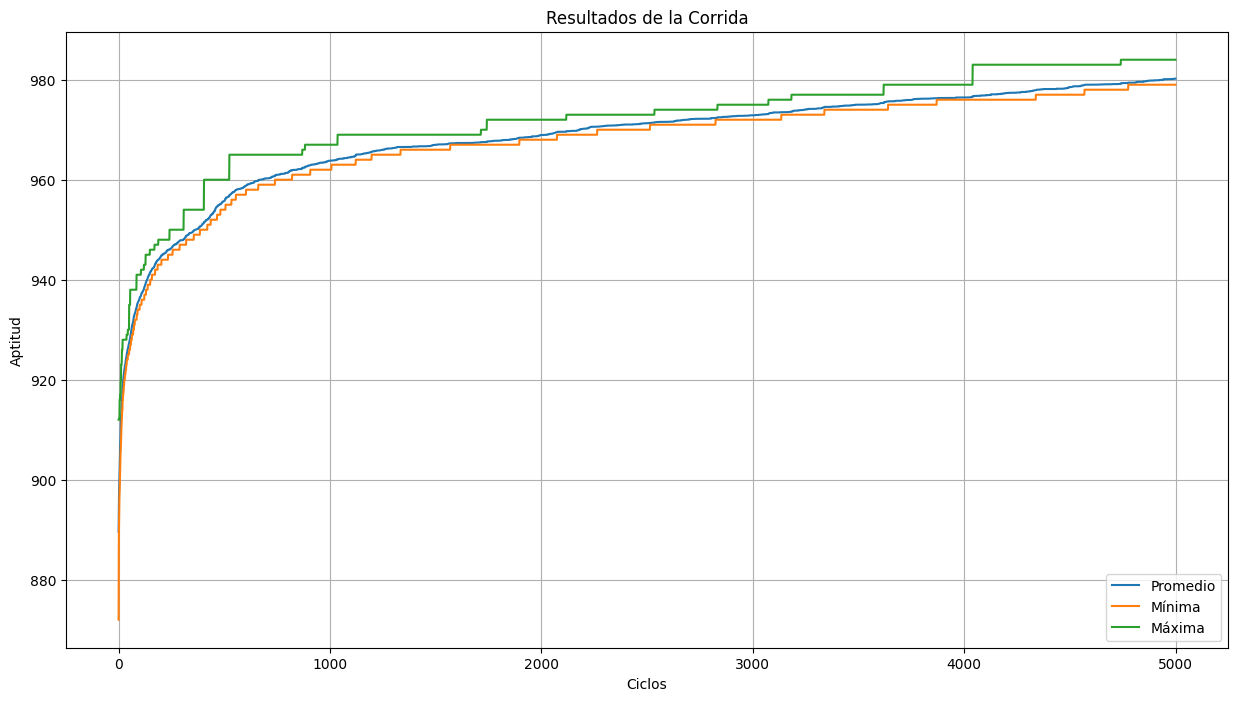

In [9]:
#@title MOSTRAR GRAFICO DE LA CORRIDA
plt.figure(figsize=(15,8))
plt.plot(ciclosPromAptitud)
plt.plot(ciclosMinAptitud)
plt.plot(ciclosMaxAptitud)
plt.title('Resultados de la Corrida')
plt.xlabel('Ciclos')
plt.ylabel('Aptitud')
plt.legend(['Promedio', 'Mínima', 'Máxima'], loc='lower right')
plt.grid(True)
plt.show()
